# How does this new model adapt under changes in the stimulus distribution?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib
import glob
import torch

In [2]:
from basicModel import EstimateAngle_Faces_final
from datageneration.faces.rotated_olivetti import FaceDataset

## initial finetuning sweep

Notably, this run used:
1. the same number of fine-tuning points as there were initial training points
2. no frozen weights in the network

### Linear loss

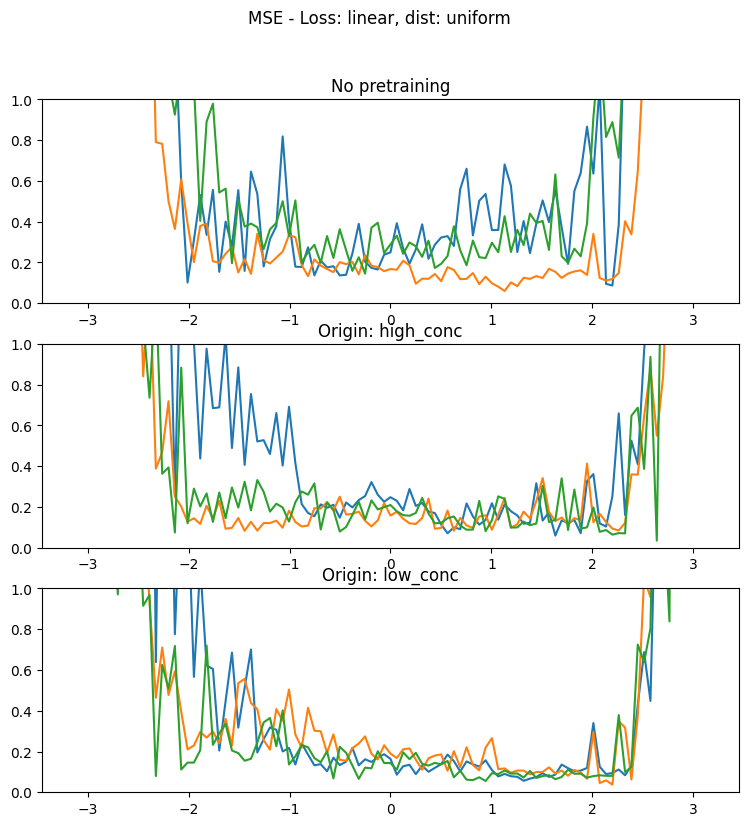

In [3]:
loss = 'linear'
dist = 'uniform'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'MSE - Loss: {loss}, dist: {dist}')

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
theta_plot = thetas.reshape((100, 101)).mean(dim=0)

stimuli = FaceDataset(thetas, split='test').images.contiguous()

def find_errors(model):
    outputs = model.decodeAngles(model.forward(stimuli.to(model.device)))
    errors = ((outputs.cpu() - thetas)**2).reshape(100, 101).mean(dim=0).cpu().detach().numpy()
    return errors


dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_errors(pretrain_model))
    plt.ylim([0,1])
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0,1])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_errors(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0,1])

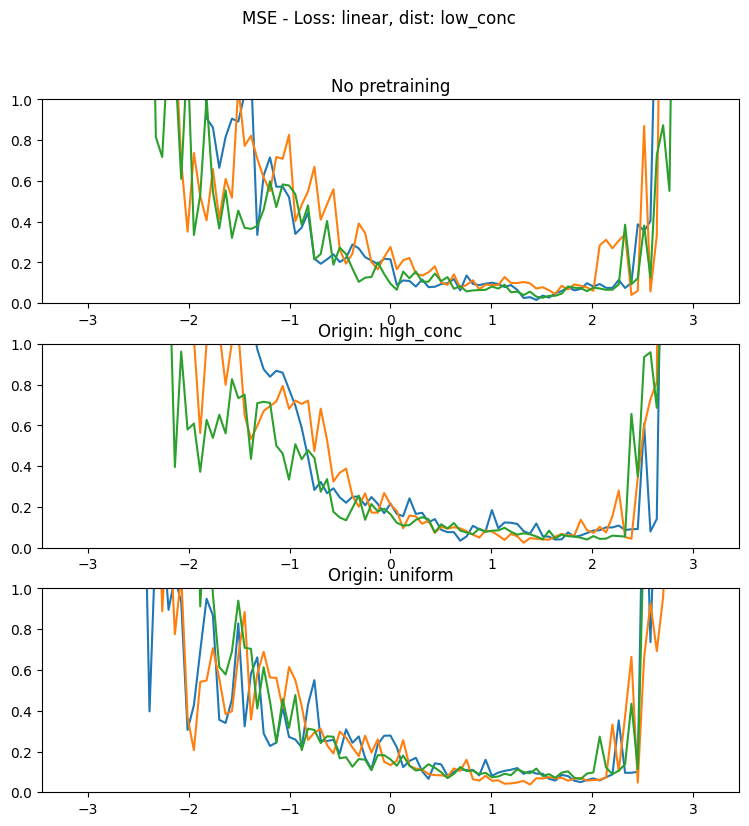

In [4]:
loss = 'linear'
dist = 'low_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'MSE - Loss: {loss}, dist: {dist}')

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
theta_plot = thetas.reshape((100, 101)).mean(dim=0)

stimuli = FaceDataset(thetas, split='test').images.contiguous()

def find_errors(model):
    outputs = model.decodeAngles(model.forward(stimuli.to(model.device)))
    errors = ((outputs.cpu() - thetas)**2).reshape(100, 101).mean(dim=0).cpu().detach().numpy()
    return errors


dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_errors(pretrain_model))
    plt.ylim([0,1])
    
    if rep == 0:
        plt.title(f'No pretraining')

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_errors(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0,1])

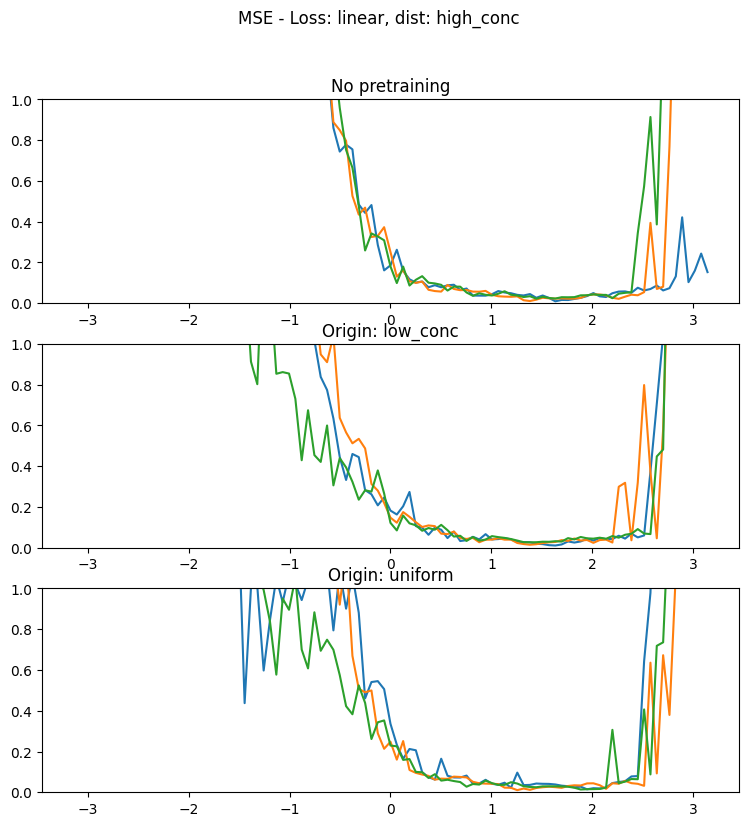

In [5]:
loss = 'linear'
dist = 'high_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'MSE - Loss: {loss}, dist: {dist}')

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
theta_plot = thetas.reshape((100, 101)).mean(dim=0)

stimuli = FaceDataset(thetas, split='test').images.contiguous()

def find_errors(model):
    outputs = model.decodeAngles(model.forward(stimuli.to(model.device)))
    errors = ((outputs.cpu() - thetas)**2).reshape(100, 101).mean(dim=0).cpu().detach().numpy()
    return errors


dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_errors(pretrain_model))
    plt.ylim([0,1])
    
    if rep == 0:
        plt.title(f'No pretraining')

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_errors(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0,1])

### observations:
1. The pre-training doesn't seem to have much effect on the final ouputs for concentrated distributions.
2. Pre-training _may_ impact uniform finetuning. It's a bit subtle, but definitely seems to be present.
   - low-concentration looks less like the uniform pre-train than high concentration! This seems like a case where 'good-enough' prevents learning.
   - This result reminds me a lot of the hysteresis argument: it is easier to learn to concentrate on a specific region than to spread out your sensitivity.
  
3. I really need a better way to visualize these things that doesn't fall prey to the mod 2pi errors

## Establishing a new error visualization method

Let's establish an error visualization that doesn't depend on the 

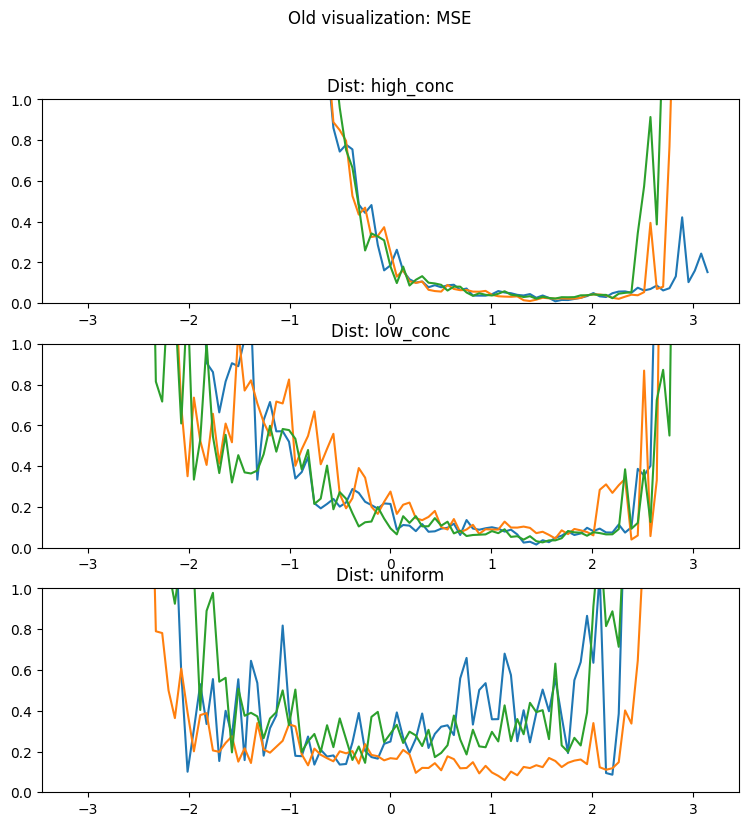

In [6]:
ckpt_dir = 'trainedParameters/Exp8/dropout/'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle('Old visualization: MSE')

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
stimuli = FaceDataset(thetas, split='test').images.contiguous()

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    for i, dist in enumerate(dists):
        ckpt = glob.glob(ckpt_dir + f'linear/{dist}/rep{rep}/epoch*')[0]
        
        model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
        outputs = model.decodeAngles(model.forward(stimuli.to(model.device)))

        errors = ((outputs.cpu() - thetas)**2).reshape(100, 101).mean(dim=0)
        t2 = thetas.reshape((100, 101)).mean(dim=0)
        plt.subplot(3,1,i+1)
        plt.plot(t2, errors.cpu().detach().numpy())
    
        if rep == 0:
            plt.title(f'Dist: {dist}')
            plt.ylim([0, 1])

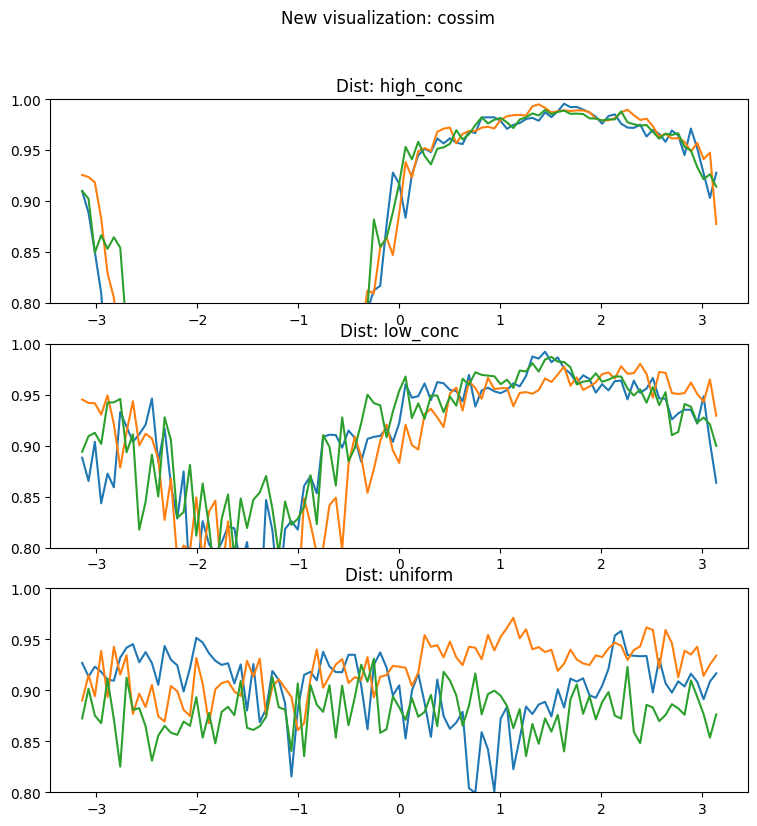

In [36]:
ckpt_dir = 'trainedParameters/Exp8/dropout/'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle('New visualization: cossim')

cos_sim = torch.nn.CosineSimilarity()

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
stimuli = FaceDataset(thetas, split='test').images.contiguous()

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    for i, dist in enumerate(dists):
        ckpt = glob.glob(ckpt_dir + f'linear/{dist}/rep{rep}/epoch*')[0]
        
        model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
        outputs = model.forward(stimuli.to(model.device)).cpu()
        encoded_inputs = model.encodeAngles(thetas)
        
        errors = cos_sim(outputs, encoded_inputs).reshape(100, 101).mean(dim=0)
        t2 = thetas.reshape((100, 101)).mean(dim=0)
        plt.subplot(3,1,i+1)
        plt.plot(t2, errors.cpu().detach().numpy())
    
        if rep == 0:
            plt.title(f'Dist: {dist}')
            plt.ylim([0.8, 1])

#### Ok, nice. I can get used to this.

__Q:__ Could there be an impact of the magnitude of the encoding vector on this readout? There isn't supposed to be. I don't think its very likely at all. The result should be identitical to the cosine similarity using normalized representations.

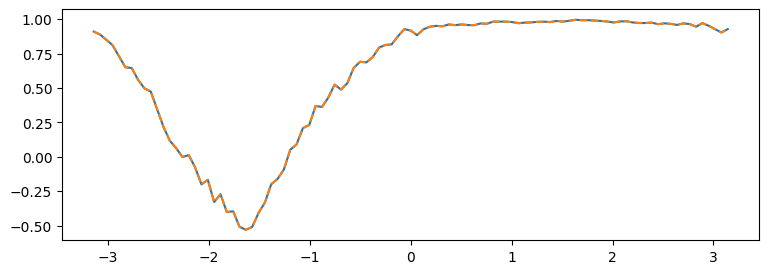

In [42]:
ckpt = glob.glob(ckpt_dir + f'linear/high_conc/rep0/epoch*')[0]
        
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    

outputs = model.forward(stimuli.to(model.device)).cpu()
encoded_inputs = model.encodeAngles(thetas)

sim1 = cos_sim(outputs, encoded_inputs).reshape(100, 101).mean(dim=0).detach()

normalized = (outputs.T / torch.norm( outputs, dim=1)).T
sim2 = cos_sim(normalized, encoded_inputs).reshape(100, 101).mean(dim=0).detach()

figsize(9,3)
plt.plot(theta_plot, sim1)
plt.plot(theta_plot, sim2, '--')
#plt.ylim([0.8, 1.])

Yep. Really no impact of the encoding 

#### This is the cosine similarity. We could also map it back to angle differences

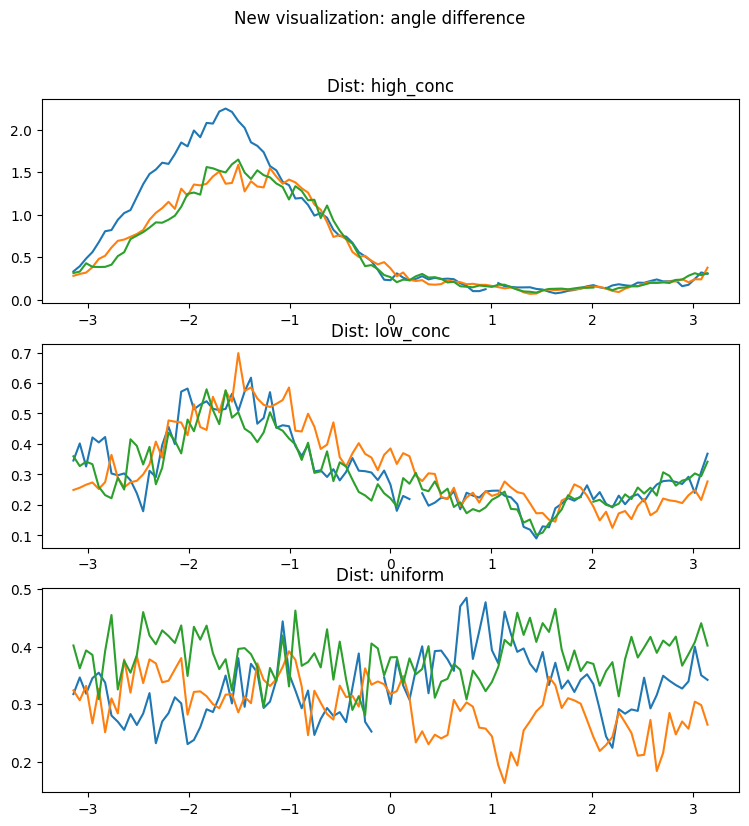

In [49]:
ckpt_dir = 'trainedParameters/Exp8/dropout/'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle('New visualization: angle difference')

cos_sim = torch.nn.CosineSimilarity()

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
stimuli = FaceDataset(thetas, split='test').images.contiguous()

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    for i, dist in enumerate(dists):
        ckpt = glob.glob(ckpt_dir + f'linear/{dist}/rep{rep}/epoch*')[0]
        
        model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
        outputs = model.forward(stimuli.to(model.device)).cpu()
        encoded_inputs = model.encodeAngles(thetas)
        
        errors = torch.arccos(cos_sim(outputs, encoded_inputs)).reshape(100, 101).mean(dim=0)
        t2 = thetas.reshape((100, 101)).mean(dim=0)
        plt.subplot(3,1,i+1)
        plt.plot(t2, errors.cpu().detach().numpy())
    
        if rep == 0:
            plt.title(f'Dist: {dist}')
            #plt.ylim([0, 0.5])

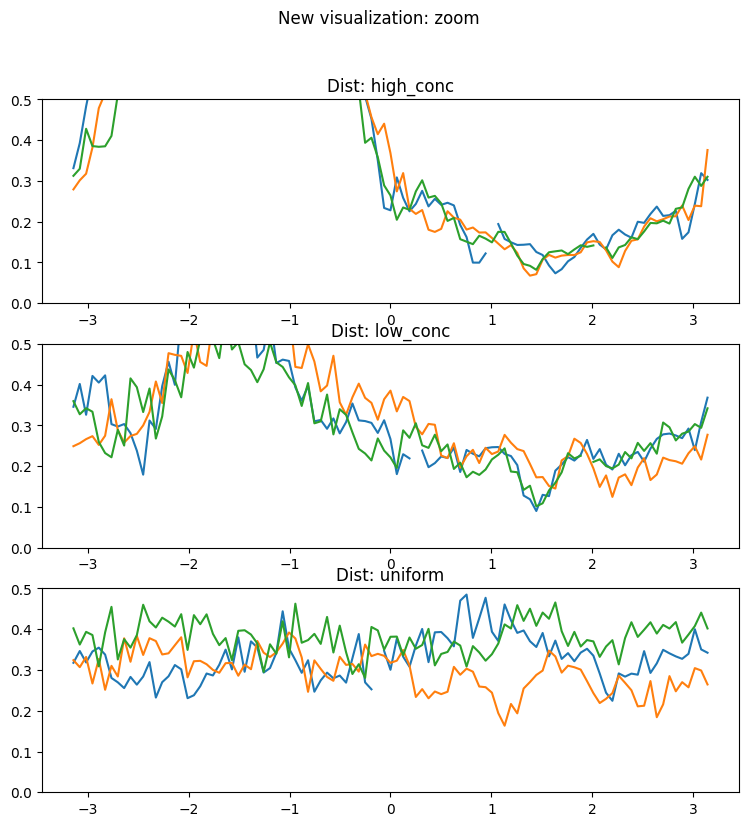

In [50]:
ckpt_dir = 'trainedParameters/Exp8/dropout/'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle('New visualization: zoom')

cos_sim = torch.nn.CosineSimilarity()

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
stimuli = FaceDataset(thetas, split='test').images.contiguous()

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    for i, dist in enumerate(dists):
        ckpt = glob.glob(ckpt_dir + f'linear/{dist}/rep{rep}/epoch*')[0]
        
        model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
        outputs = model.forward(stimuli.to(model.device)).cpu()
        encoded_inputs = model.encodeAngles(thetas)
        
        errors = torch.arccos(cos_sim(outputs, encoded_inputs)).reshape(100, 101).mean(dim=0)
        t2 = thetas.reshape((100, 101)).mean(dim=0)
        plt.subplot(3,1,i+1)
        plt.plot(t2, errors.cpu().detach().numpy())
    
        if rep == 0:
            plt.title(f'Dist: {dist}')
            plt.ylim([0, 0.5])

This looks pretty good, by why are the breaks in the lines there?

In [52]:
ckpt = glob.glob(ckpt_dir + f'linear/low_conc/rep0/epoch*')[0]

model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

outputs = model.forward(stimuli.to(model.device)).cpu()
encoded_inputs = model.encodeAngles(thetas)

errors = torch.arccos(cos_sim(outputs, encoded_inputs)).reshape(100, 101).mean(dim=0)

In [53]:
errors

tensor([0.3457, 0.4017, 0.3260, 0.4214, 0.4050, 0.4228, 0.3031, 0.2972, 0.3033,
        0.2810, 0.2381, 0.1791, 0.3119, 0.2913, 0.3964, 0.4562, 0.3995, 0.5717,
        0.5818, 0.5137, 0.5292, 0.5401, 0.5152, 0.5113, 0.5148, 0.5646, 0.5082,
        0.5720, 0.6174, 0.4664, 0.4851, 0.5700, 0.4530, 0.4613, 0.4581, 0.3933,
        0.3606, 0.3968, 0.3100, 0.3134, 0.2917, 0.3172, 0.2805, 0.3082, 0.3537,
        0.3123, 0.3106, 0.3062, 0.2815, 0.3126, 0.2664, 0.1804, 0.2293, 0.2191,
           nan, 0.2384, 0.1974, 0.2074, 0.2238, 0.2201, 0.2454, 0.1857, 0.2398,
        0.2305, 0.2241, 0.2440, 0.2464, 0.2469, 0.2300, 0.2248, 0.2026, 0.1279,
        0.1187, 0.0900, 0.1297, 0.1265, 0.1890, 0.2038, 0.2224, 0.2137, 0.2280,
        0.2644, 0.2178, 0.2419, 0.2036, 0.1917, 0.2304, 0.2022, 0.2270, 0.2349,
        0.2109, 0.2430, 0.2668, 0.2780, 0.2800, 0.2753, 0.2687, 0.2923, 0.2393,
        0.3084, 0.3681], grad_fn=<MeanBackward1>)

In [57]:
cossims = cos_sim(outputs, encoded_inputs).reshape(100, 101)

In [72]:
column_values = cossims[:, errors.isnan()]

In [76]:
nans_rows  = torch.arccos(column_values).isnan()

In [77]:
column_values[nans]

tensor([1.0000], grad_fn=<IndexBackward0>)

In [78]:
torch.arccos(column_values[nans])

tensor([nan], grad_fn=<AcosBackward0>)

In [79]:
torch.arccos(torch.tensor(1.))

tensor(0.)

In [87]:
torch.arccos(torch.tensor(1. + 1E-7))

tensor(nan)

It looks like the problem is a result of small round-off errors in the cosine similarities that are close to one.

In [96]:
torch.arccos(torch.minimum(column_values, torch.ones(column_values.shape))).isnan().any()

tensor(False)

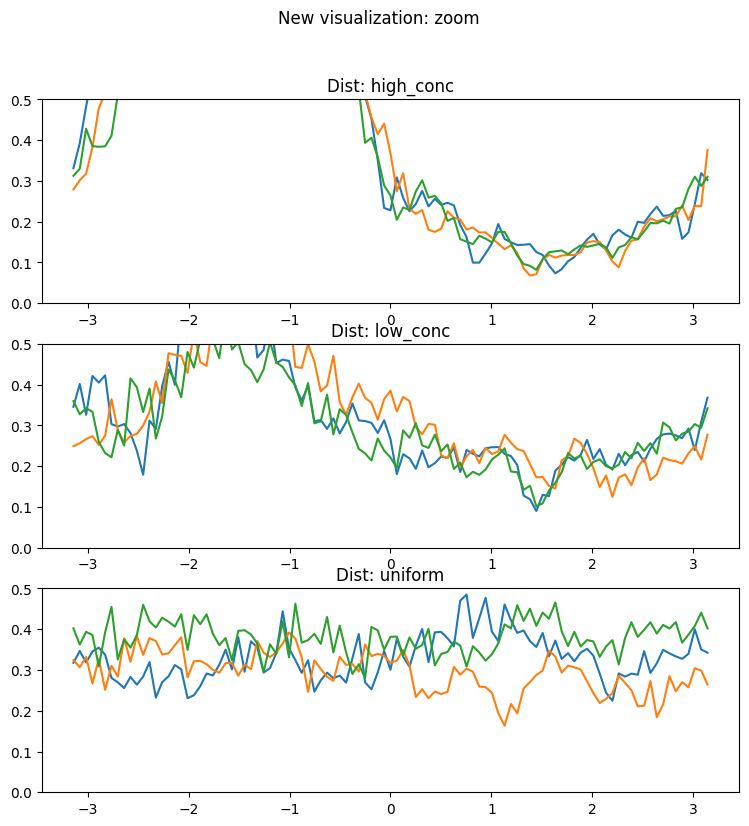

In [103]:
ckpt_dir = 'trainedParameters/Exp8/dropout/'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle('New visualization: zoom')

cosine_sim_raw = torch.nn.CosineSimilarity()
cos_sim = lambda x, y: torch.minimum(cosine_sim_raw(x, y), torch.ones(x.shape[0]))

thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
stimuli = FaceDataset(thetas, split='test').images.contiguous()

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    for i, dist in enumerate(dists):
        ckpt = glob.glob(ckpt_dir + f'linear/{dist}/rep{rep}/epoch*')[0]
        
        model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
        outputs = model.forward(stimuli.to(model.device)).cpu()
        encoded_inputs = model.encodeAngles(thetas)
        
        errors = torch.arccos(cos_sim(outputs, encoded_inputs)).reshape(100, 101).mean(dim=0)
        t2 = thetas.reshape((100, 101)).mean(dim=0)
        plt.subplot(3,1,i+1)
        plt.plot(t2, errors.cpu().detach().numpy())
    
        if rep == 0:
            plt.title(f'Dist: {dist}')
            plt.ylim([0, 0.5])

Fixed, but this is an important failure mode.

## Finetuning results

In [127]:
thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
theta_plot = thetas.reshape((100, 101)).mean(dim=0)

stimuli = FaceDataset(thetas, split='test').images.contiguous()

cos_sim = torch.nn.CosineSimilarity()

def find_error(model):
    outputs = model.forward(stimuli.to(model.device)).cpu()
    encoded_inputs = model.encodeAngles(thetas)

    sim = cos_sim(outputs, encoded_inputs).reshape(100, 101).mean(dim=0)
    error = torch.arccos(torch.minimum(sim, torch.ones(sim.shape)))
    return error.detach().numpy()

def find_sim(model):
    outputs = model.forward(stimuli.to(model.device)).cpu()
    encoded_inputs = model.encodeAngles(thetas)

    sim = cos_sim(outputs, encoded_inputs).reshape(100, 101).mean(dim=0)
    return sim.detach().numpy()

### Linear Loss

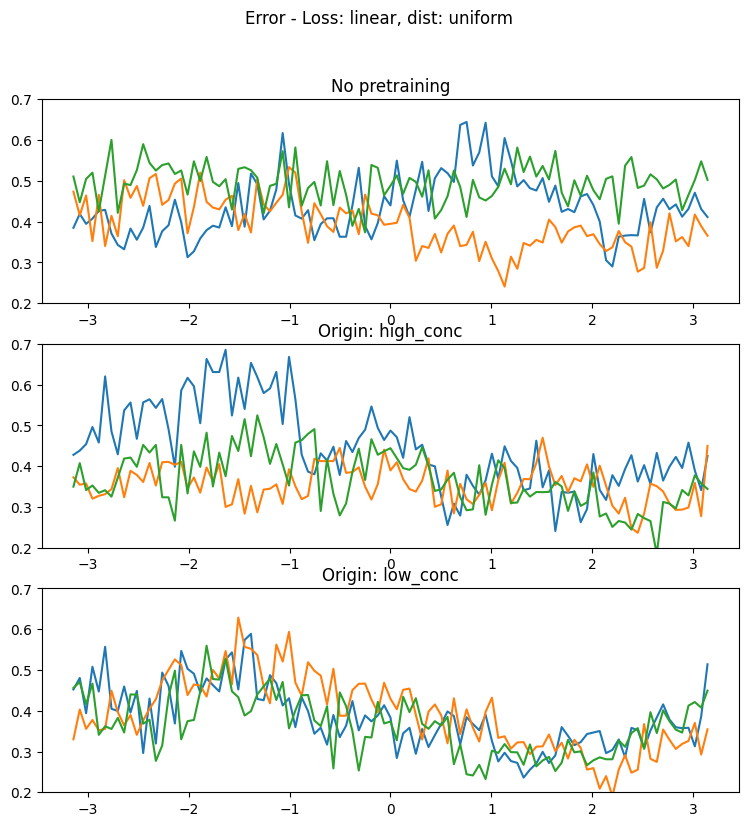

In [124]:
loss = 'linear'
dist = 'uniform'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.2, 0.7])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.2, 0.7])

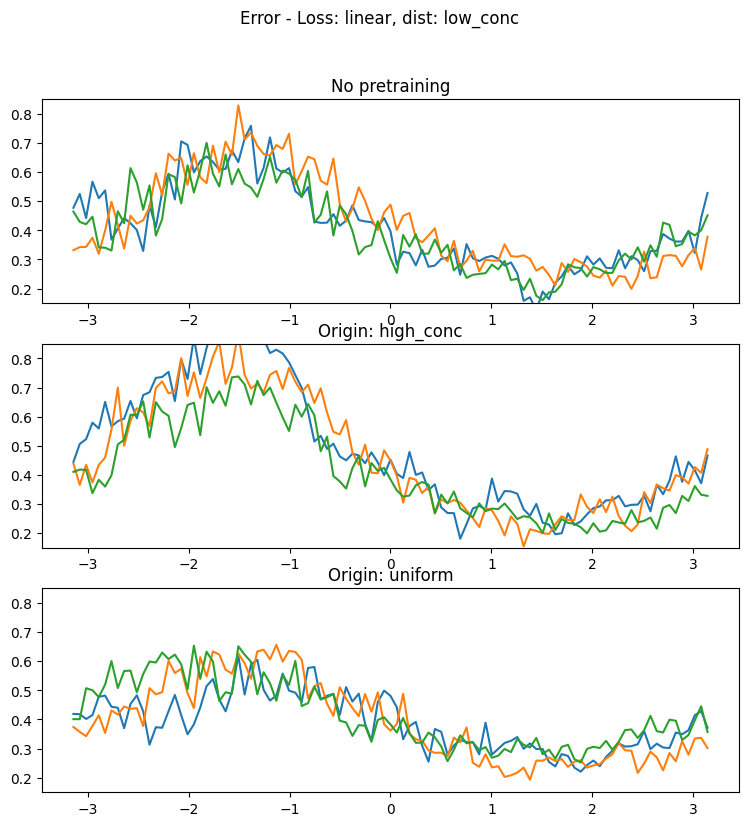

In [125]:
loss = 'linear'
dist = 'low_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.15, 0.85])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.15, 0.85])

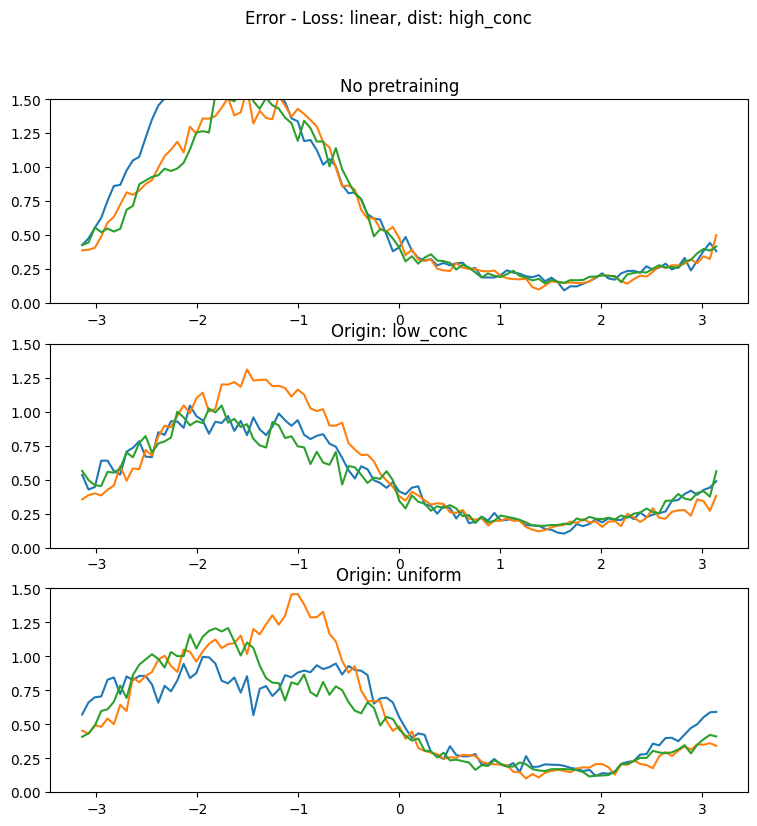

In [126]:
loss = 'linear'
dist = 'high_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0., 1.5])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0., 1.5])

#### Observations:

In this metric, we can see that there is indeed some impact of pretraining on the similarity curves. 
Generally, this shows up as lower errors in low probability regions when moving less -> more concentrated, and lower errors in the formerly high probability regions when moving more -> less concentrated.

That is to say, it is  generally harder for the networks to forget good performance than to learn good performance.
- this makes sense with the adaptation method. 
- this is also the core of the hysteresis idea.

### Sqrt loss

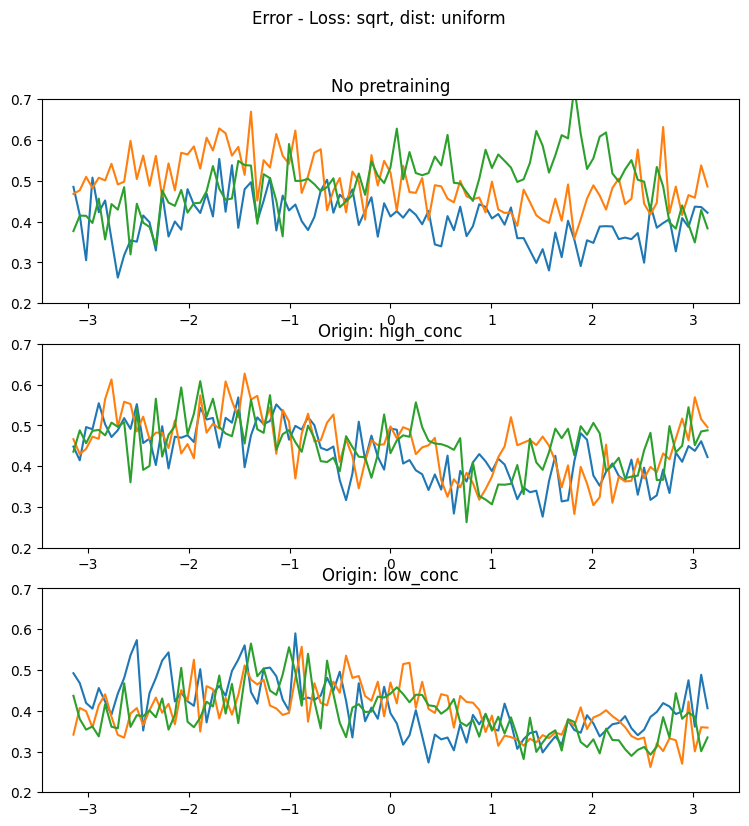

In [136]:
loss = 'sqrt'
dist = 'uniform'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.2, 0.7])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.2, 0.7])

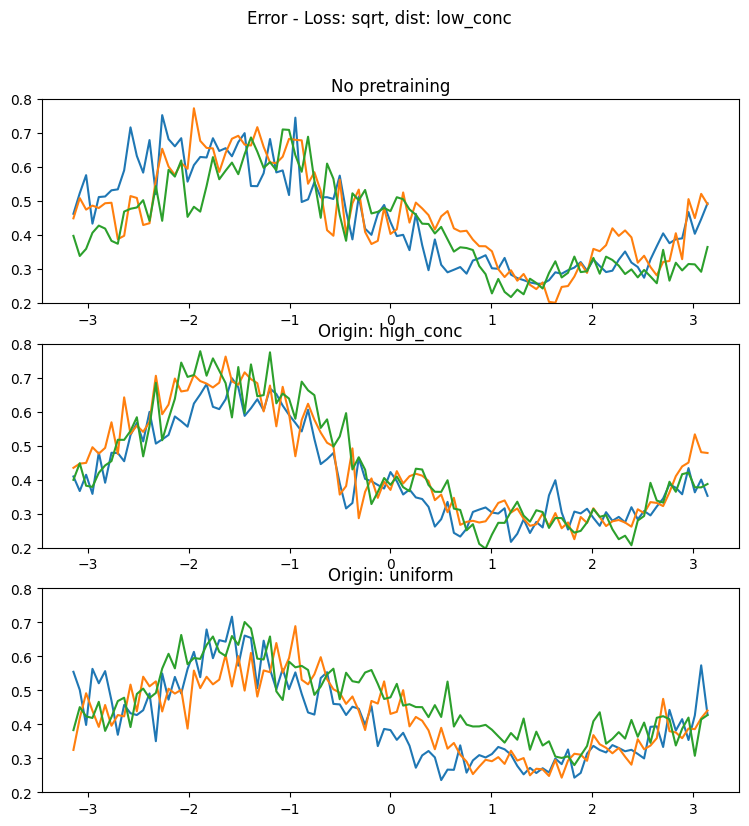

In [140]:
loss = 'sqrt'
dist = 'low_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.2, 0.8])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.2, 0.8])

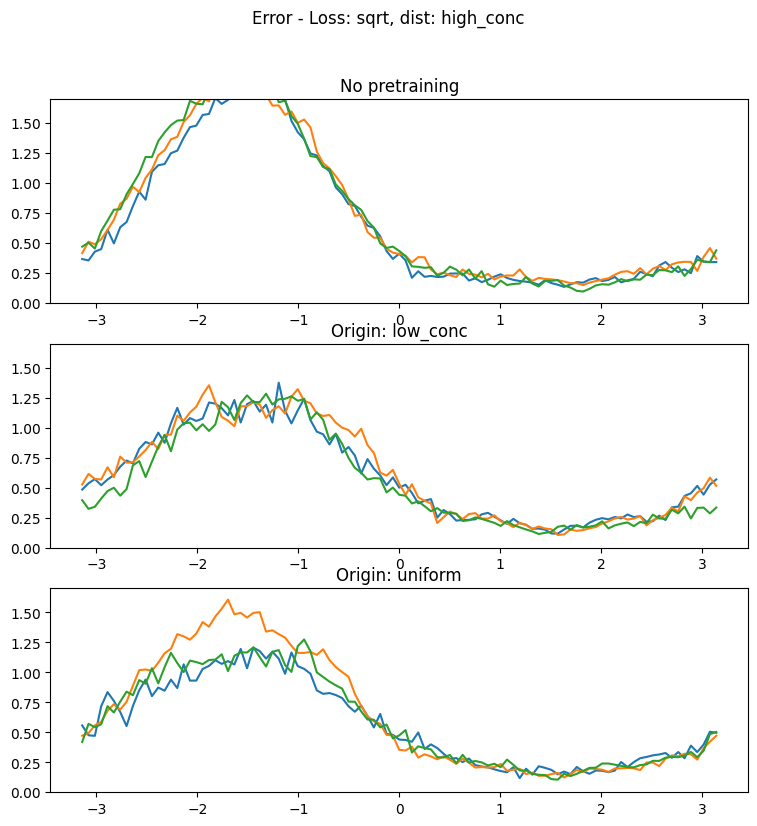

In [143]:
loss = 'sqrt'
dist = 'high_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0., 1.7])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0., 1.7])

### Log Loss

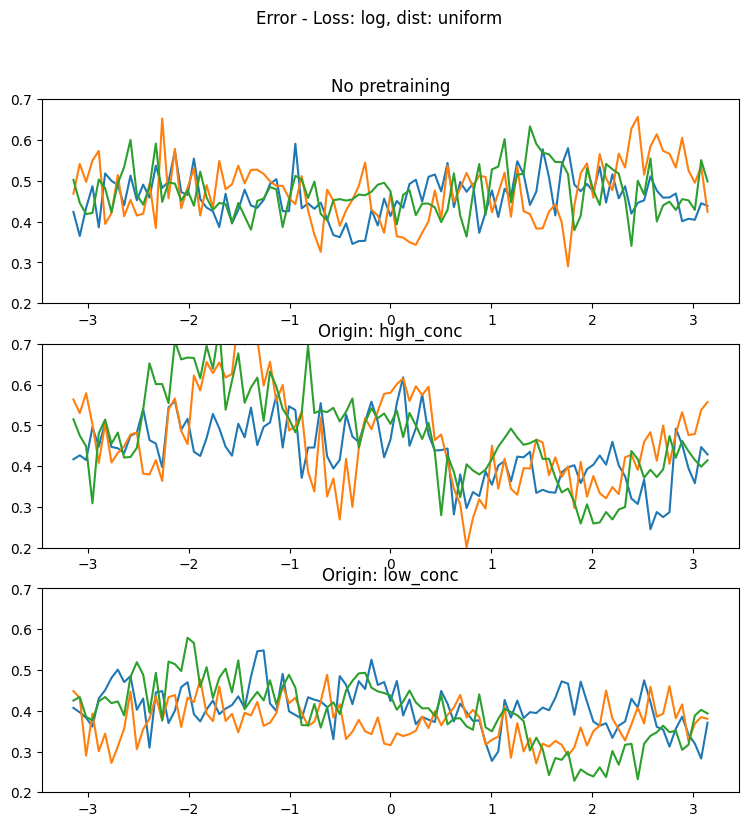

In [147]:
loss = 'log'
dist = 'uniform'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.2, 0.7])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.2, 0.7])

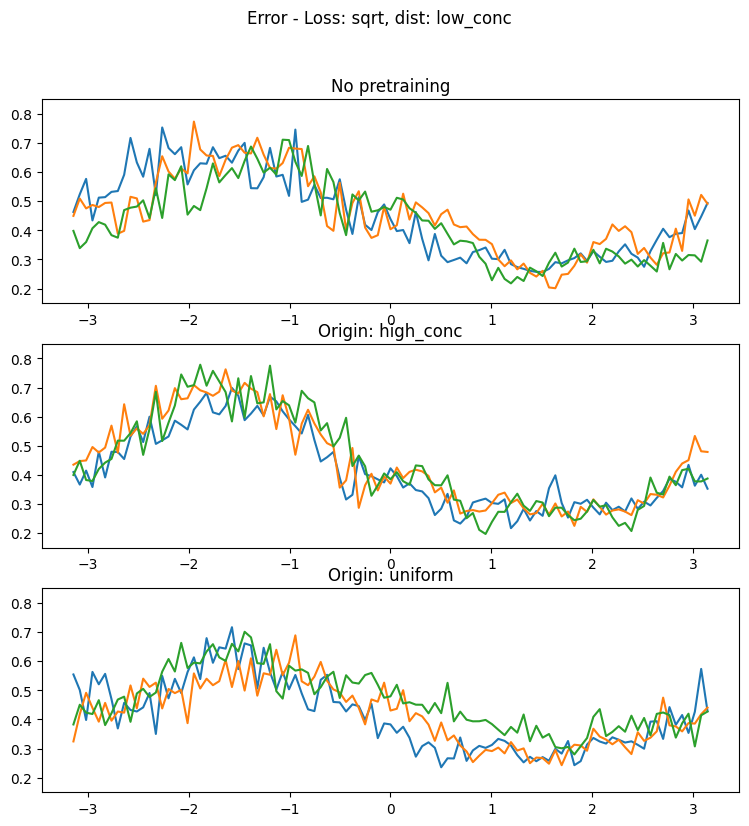

In [148]:
loss = 'sqrt'
dist = 'low_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.15, 0.85])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.15, 0.85])

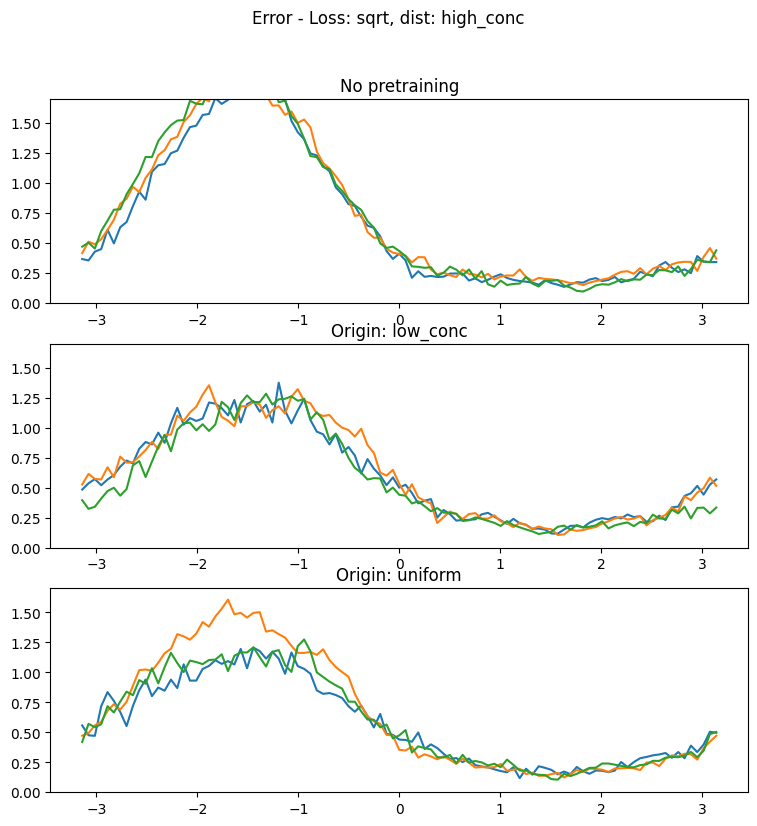

In [152]:
loss = 'sqrt'
dist = 'high_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - Loss: {loss}, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/{loss}/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model))
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0., 1.7])

    i = 2
    for origin in dists:
        if origin == dist:
            continue
        finetune_ckpt = glob.glob(f'trainedParameters/Exp9/finetune/{loss}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
        finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                       loss_pair=('linear', lambda d:d))

        plt.subplot(3,1,i)
        plt.plot(theta_plot, find_error(finetune_model))

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0., 1.7])

#### Loss function effects

These are hard to see. Maybe there is a slight effect in the way the errors curve up, but not easy to tell by eye.

One the other hand, there are clear effects from pre-training! This is good. It might be even better to use smaller fine-tuning data sets.

## Finetuning with different numbers of training points


Color scheme: cooler means more datapoints

In [3]:
thetas = torch.linspace(-np.pi, np.pi, 101).repeat(100,1)
thetas = thetas.reshape(-1)
theta_plot = thetas.reshape((100, 101)).mean(dim=0)

stimuli = FaceDataset(thetas, split='test').images.contiguous()

cos_sim = torch.nn.CosineSimilarity()

def find_error(model):
    outputs = model.forward(stimuli.to(model.device)).cpu()
    encoded_inputs = model.encodeAngles(thetas)

    sim = cos_sim(outputs, encoded_inputs).reshape(100, 101).mean(dim=0)
    error = torch.arccos(torch.minimum(sim, torch.ones(sim.shape)))
    return error.detach().numpy()

def find_sim(model):
    outputs = model.forward(stimuli.to(model.device)).cpu()
    encoded_inputs = model.encodeAngles(thetas)

    sim = cos_sim(outputs, encoded_inputs).reshape(100, 101).mean(dim=0)
    return sim.detach().numpy()

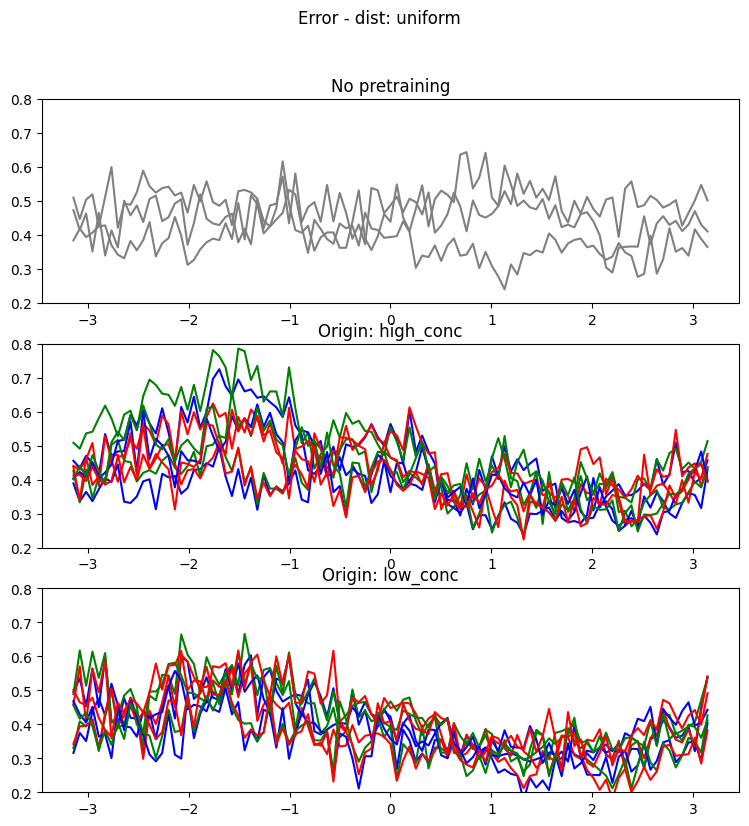

In [27]:
dist = 'uniform'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.2, 0.8])

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for size in [512, 256, 128]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/size_sweep/size{size}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {512:'b', 256:'g', 128:'r'}
            color = colors[size]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.2, 0.8])

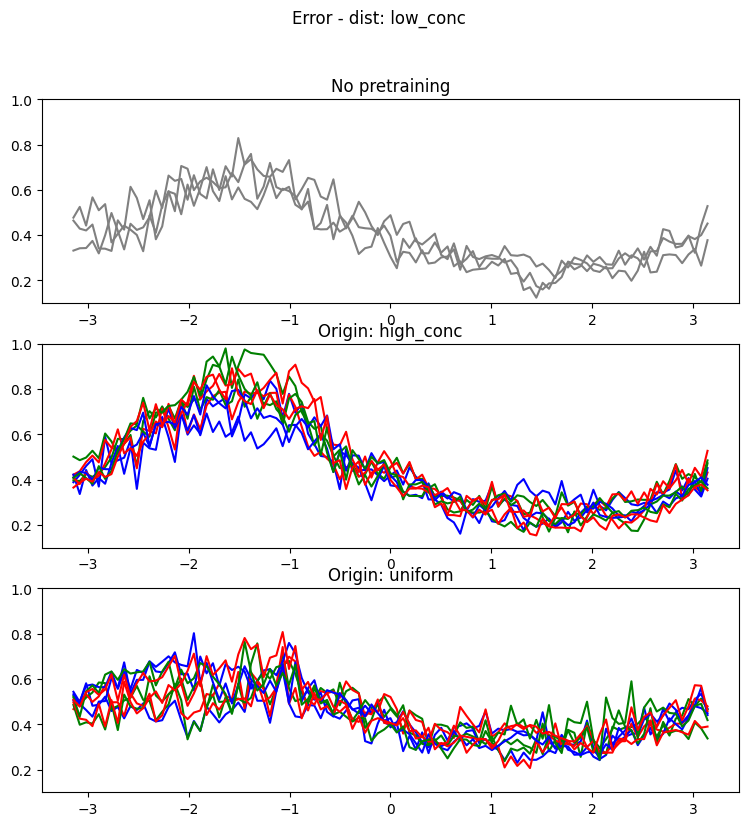

In [28]:
dist = 'low_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0.1, 1.])

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for size in [512, 256, 128]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/size_sweep/size{size}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {512:'b', 256:'g', 128:'r'}
            color = colors[size]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0.1, 1.])

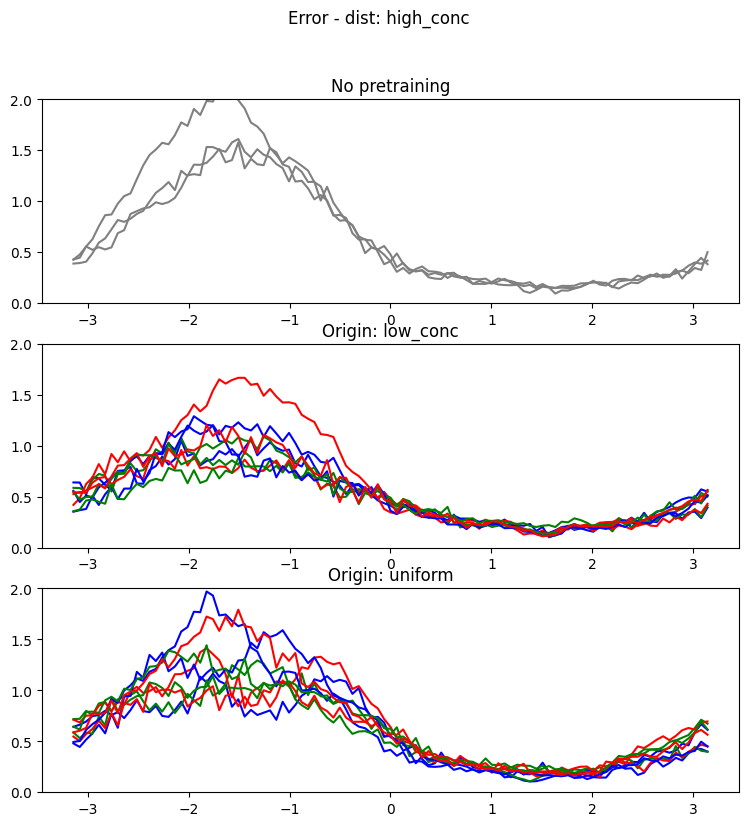

In [29]:
dist = 'high_conc'

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim([0., 2.])

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for size in [512, 256, 128]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/size_sweep/size{size}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {512:'b', 256:'g', 128:'r'}
            color = colors[size]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim([0., 2.])

### Observations:

There is, interestingly, much less impact than I expected from changing the size of finetuning set. Granted, I didn't make the tuning set less that 1000 data points, so going even lower might have greater effect.
Going plot by plot:
- uniform: I don't think there's any difference. A couple of red and green runs stayed high on the left after high_conc, but really, nothing.
- low concentration: high concentration _maybe_ learned better with more data. (blue seems flatter than green and red)
- high concentration: interestingly, 128 had some very luck runs. Similarly with 512. Note that this is for _unlearning_ sensitivity. Coming from uniform, 512 was the best at learning high precision. This doesn't hold up for low-concentration.



### Lower dataset sizes:
- These train very fast and, many of them see little improvement outside of the early training.


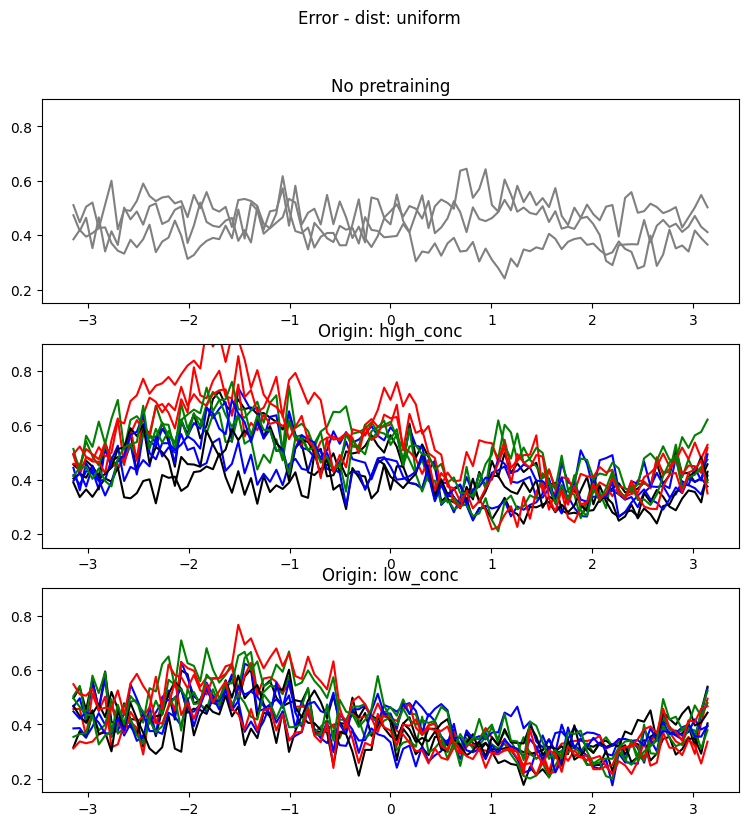

In [34]:
dist = 'uniform'
ylim = [0.15, 0.9]

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim(ylim)

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for size in [512, 64, 32, 16]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/size_sweep/size{size}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {512:'k', 64: 'b', 32:'g', 16:'r'}
            color = colors[size]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim(ylim)

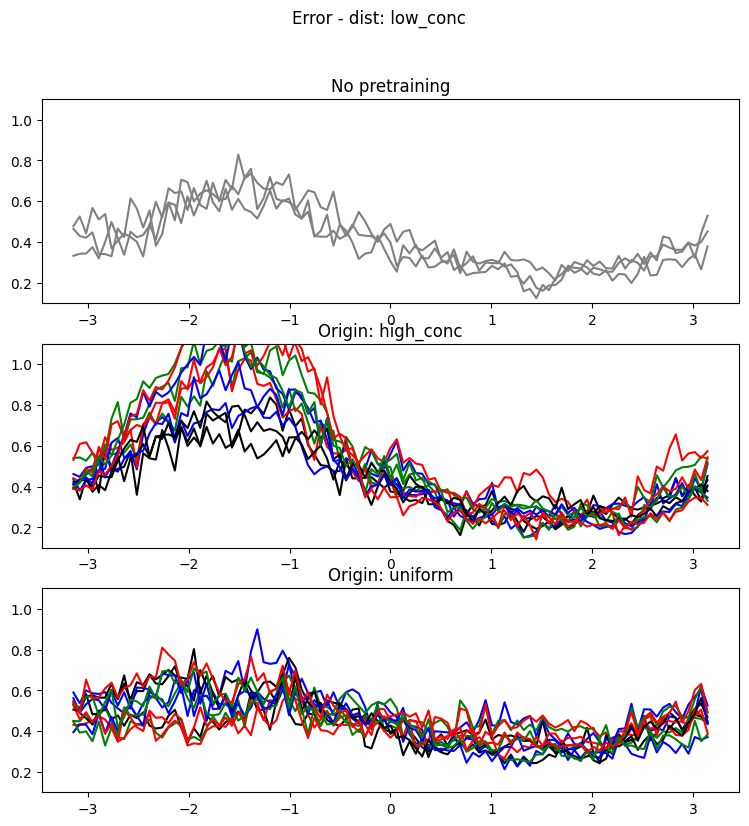

In [37]:
dist = 'low_conc'
ylim = [0.1, 1.1]

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim(ylim)

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for size in [512, 64, 32, 16]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/size_sweep/size{size}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {512:'k', 64: 'b', 32:'g', 16:'r'}
            color = colors[size]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim(ylim)

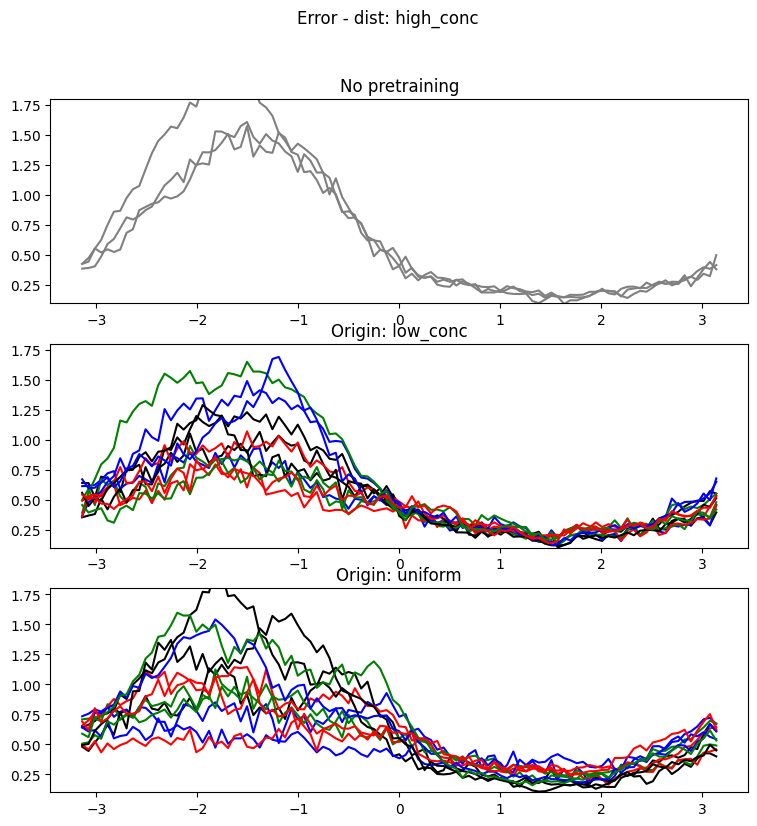

In [41]:
dist = 'high_conc'
ylim = [0.1, 1.8]

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim(ylim)

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for size in [512, 64, 32, 16]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/size_sweep/size{size}/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {512:'k', 64: 'b', 32:'g', 16:'r'}
            color = colors[size]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim(ylim)

#### Observations:
(Note: cooler is more training points)

These are pretty much perfect results.
- coming from more concentrated distributions we stayed more concentrated.
- coming from less concentrated distributions we stayed less concentrated.
- There is clear difference between 512 finetuning and the lower numbers of points. Particularly 16, but really all of them work fairly well.

- uniform -> low conc is pretty noisy
- x -> high conc we still see the influence of 'luck' in unlearning.

- Overall, I'm a little concerned about the level of noise between the curves. This will probably increase with fewer fine-tuning points, so that is a concern. What if we instead try freezing some layers?

## Freezing layers during finetuning

Full data size, finetuning with frozen layers.

In [84]:
concentratedConfig = {
         'loc_tr': np.pi/2,
         'kappa_tr': 3.,
         'loc_val': np.pi/2,
         'kappa_val': 3.,
         'loc_test': np.pi/2,
         'kappa_test': 3.
         }

model = EstimateAngle_Faces_final.load_from_checkpoint(
    'trainedParameters/Exp8/dropout/linear/uniform/rep0/epoch=105-step=27136.ckpt',
    loss_pair=('linear', lambda d: 2. - torch.mean(d)),
    **concentratedConfig)

In [85]:
old_params = []

for i, param in enumerate(model.parameters()):
    old_params.append(param.data.clone().cpu())
    if i < 4:
        param.requires_grad = False

In [86]:
from trainers import trainModel

In [87]:
trainModel(model, 'trainedParameters/_test')

wandb: Currently logged in as: lrast. Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/luke/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name   | Type             | Params
--------------------------------------------
0 | model  | Sequential       | 123 K 
1 | cosSim | CosineSimilarity | 0     
--------------------------------------------
22        Trainable params
123 K     Non-trainable params
123 K     Total params
0.493     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

'/Users/luke/Documents/angleFinetuning/trainedParameters/_test/epoch=83-step=21504.ckpt'

In [88]:
new_params = []
for param in model.parameters():
    new_params.append(param.data.clone().cpu())

In [93]:
for i in range(6):
    print( (old_params[i] - new_params[i]).max() )

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.1107)
tensor(-0.0308)


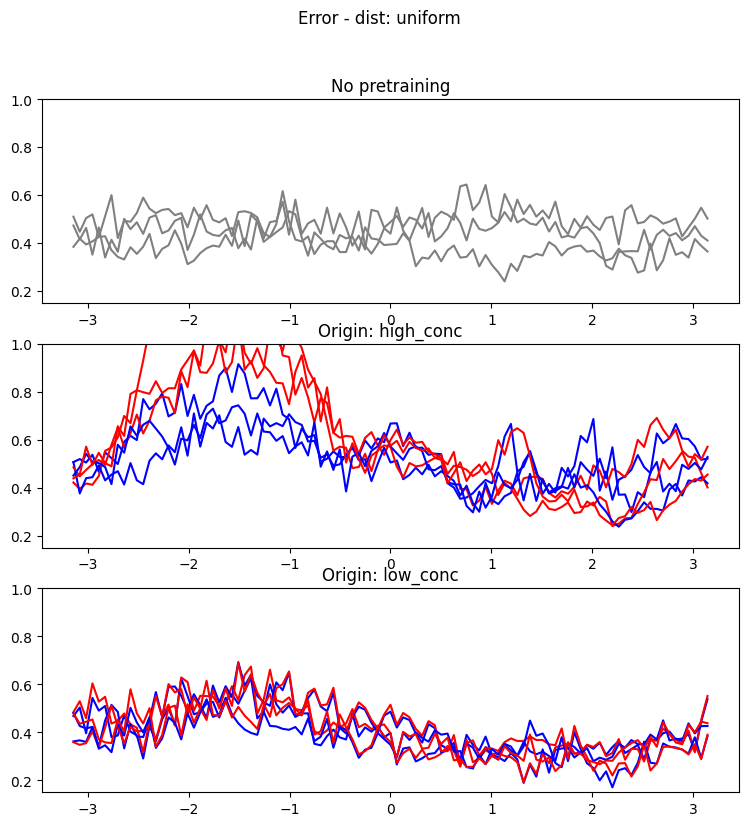

In [96]:
dist = 'uniform'
ylim = [0.15, 1.0]

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - frozen layers, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim(ylim)

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for frozen in [1, 2]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/freeze_layers/{frozen}layers/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {1:'b', 2:'r'}
            color = colors[frozen]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim(ylim)

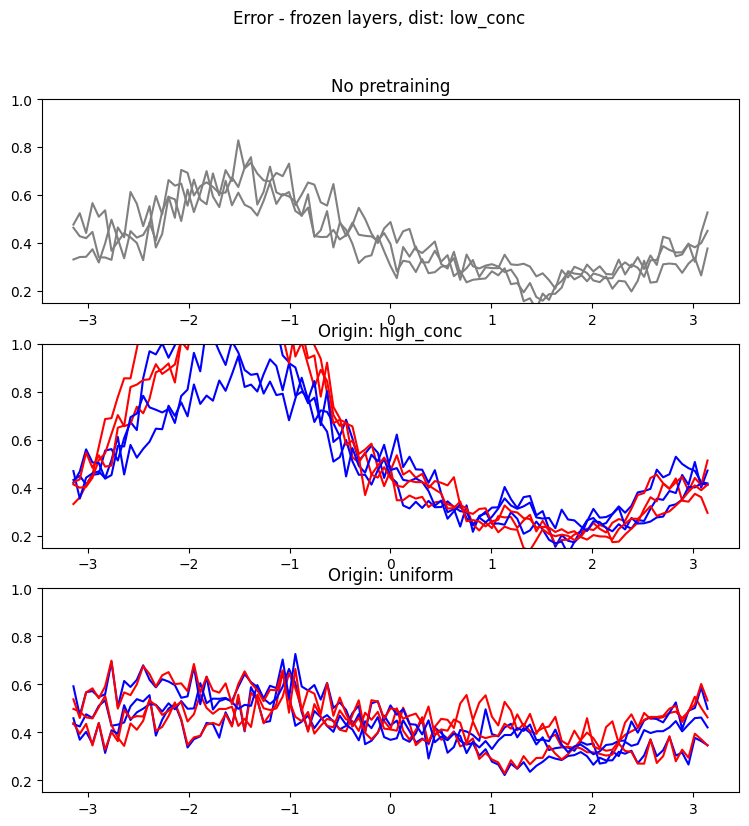

In [98]:
dist = 'low_conc'
ylim = [0.15, 1.0]

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - frozen layers, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim(ylim)

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for frozen in [1, 2]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/freeze_layers/{frozen}layers/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {1:'b', 2:'r'}
            color = colors[frozen]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim(ylim)

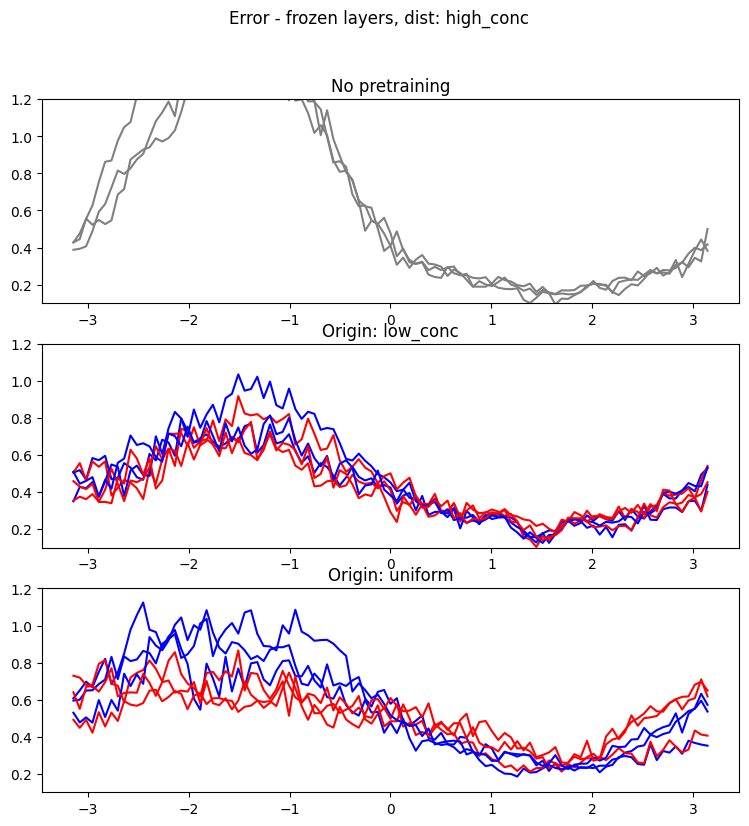

In [103]:
dist = 'high_conc'
ylim = [0.1, 1.2]

figsize(9,9)
plt.subplots(3,1)
plt.suptitle(f'Error - frozen layers, dist: {dist}')

dists = ['high_conc', 'low_conc', 'uniform']

for rep in range(3):
    pretrain_ckpt =  glob.glob(f'trainedParameters/Exp8/dropout/linear/{dist}/rep{rep}/epoch*')[0]
    pretrain_model = EstimateAngle_Faces_final.load_from_checkpoint(pretrain_ckpt,
                                                                    loss_pair=('linear', lambda d:d)
                                                                   )
    plt.subplot(3,1,1)
    plt.plot(theta_plot, find_error(pretrain_model), color='gray')
    
    if rep == 0:
        plt.title(f'No pretraining')
        plt.ylim(ylim)

    i = 2
    for origin in dists:
        if origin == dist:
            continue

        for frozen in [1, 2]:
            finetune_ckpt = glob.glob(f'trainedParameters/Exp9/freeze_layers/{frozen}layers/{origin}_to_{dist}/rep{rep}/epoch*')[0]
            finetune_model = EstimateAngle_Faces_final.load_from_checkpoint(finetune_ckpt,
                                                                           loss_pair=('linear', lambda d:d))

            colors = {1:'b', 2:'r'}
            color = colors[frozen]
            plt.subplot(3,1,i)
            plt.plot(theta_plot, find_error(finetune_model), color=color)

        i += 1
        if rep == 0:
            plt.title(f'Origin: {origin}')
            plt.ylim(ylim)

#### Observations:
This honestly looks great too. 
- not sure if its any less noisy, but I do think that there is a clearer separation between the different levels of freezing, which is nice if I want to do things in degrees.
- uniform <-> low conc again showing less separation.